### Least squares equalizer for BPSK channel with additive Gaussian noise.

##### TO DO: allow for complex inputs (e.g., non-binary channels).

In [1]:
import numpy as np
import numpy as np
from scipy import signal as sig, linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
"""Main function for generating metrics for the least squares equalizer.
   Params should include: {channel_length, snr, preamble_length}"""
def test(params={'channel_length':2, 'equalizer_L':2, 'snr':1, 'preamble_length':100}, runs=1):
    # extract parameters
    channel_length = params['channel_length']
    L = params['equalizer_L']
    equalizer_length = 2*L +1
    snr = params['snr']
    preamble_length = params['preamble_length']
    avg_bit_error = 0.
    avg_baseline_error = 0.
    for i in range(runs):
        # generate random channel, with normalized coefficients
        channel = generate_random_channel(channel_length)
        channel = channel / np.linalg.norm(channel)
        # generate train data [the preamble]
        train_data = generate_data(preamble_length)
        received_train_data = apply_channel(channel, train_data, snr)
        # generate test data
        test_data = generate_data(int(1e2))
        received_test_data = apply_channel(channel, test_data, snr)
        # gradient descent
        h_E = learn_equalizer(L, channel_length, received_train_data, train_data, ALG=1)
        # recover message
        decoded = apply_channel(h_E, received_test_data)
        decoded = decoded[L:-(channel_length+equalizer_length-2-L)]
        baseline = received_test_data[:-(channel_length-1)]
        # test on output
        avg_bit_error += bit_error(decoded, test_data)
        avg_baseline_error += bit_error(baseline, test_data)
    return avg_bit_error / (len(test_data)*runs), avg_baseline_error / (len(test_data)*runs)

In [18]:
"""Generate a channel with N taps."""
def generate_random_channel(n):
    return np.random.randn(n)

"""Generate data to send for the BPSK channel."""
def generate_data(n):
    return np.random.choice([-1, 1], n).astype(np.float64)

"""Add Gaussian noise with variance AMPLITUDE to SIGNAL."""
def add_noise(signal, amplitude): 
    return signal + np.sqrt(amplitude) * np.random.randn(len(signal))

In [19]:
"""Apply CHANNEL to CHANNEL_INPUT, with added Gaussian noise such that the
   signal to noise ration (SNR) is as input. 

   Set SNR to -1 for no noise."""
def apply_channel(channel, channel_input, snr=-1):
    out = sig.convolve(channel_input, channel, mode="full")
    # SNR: signal power is fixed at 1 in our model, so just scale the noise
    if snr > 0:
        out = add_noise(out, 1./snr)
    return out

# """Generates the toeplitz matrix to perform least squares on."""
# def gen_toeplitz(received_signal, channel_length, equalizer_length):
#     # offset_amount needs to be same as in "test ()"
#     offset_amount = (equalizer_length+1) // 2
#     row = np.hstack((received_signal[:offset_amount], np.zeros(equalizer_length-offset_amount)))
#     # handle edge case
#     if -channel_length+offset_amount >= 0:
#         offset_amount2 = len(received_signal)
#     else:
#         offset_amount2 = -channel_length+offset_amount
#     col = received_signal[offset_amount:offset_amount2]
#     col = np.hstack((col, np.zeros(len(received_signal)-channel_length+1-len(col))))
#     toeplitz = la.toeplitz(col,row)
#     return toeplitz

def gen_matrix(signal, pre_chan_sig_len, L):  
    order = 2*L+1
    A = []
    signal = np.pad(signal.flatten(), L, 'constant', constant_values=(0))
    for i in range(pre_chan_sig_len):
        A += [np.flip(signal[i: i+order],0)]
    return np.array(A)

In [20]:
"""USE LMS algorithm. In general, seek to minimize error: np.linalg.norm(np.dot(A, h) - b)**2

   Channel length: H_LEN
   Received symbols: X
   Sent symbols: Y
   Iterate for: STEPS
   Learning rate: LR."""
def learn_equalizer(L, channel_length, 
        received_signal, sent_signal, steps=10, LR=0.05, ALG=2):
    equalizer_length = L*2+1
    A = gen_matrix(received_signal, len(sent_signal), L)
    b = sent_signal
    h = np.zeros(equalizer_length)
    # Use closed form least squares solution [sanity check]
    if ALG == 0:
        h,_,_,_ = np.linalg.lstsq(A, b,rcond=-1)
    # Using gradient descent [method 1]
    if ALG == 1:
        while steps > 0:
            grad_update = np.dot(A.T, np.dot(A, h) - b)
            h = h - (LR / len(b))*grad_update
            steps -= 1
    # Using LMS [method 2, default]
    if ALG == 2:
        for r in range(len(A)):
            grad_update = (np.dot(A[r],h) - b[r]) * A[r]
            h = h - LR*grad_update
    return h

In [21]:
"""Calculate the number of bit errors between DECODED and SENT.
   Assumes binary channel (values sent are +1 or -1)."""
def bit_error(decoded, sent):
    num_errors = 0
    temp = np.copy(decoded)
    temp[temp<0] = -1
    temp[temp>=0] = 1
    return 0.5*np.sum((np.abs(temp-sent)))

In [22]:
"""Plots with respect to an input metric (METRIC_NAME).
   Tune RUNS to get smooth plots, and LOG to plot on a log scale."""
def plot_metric(metric_name, metric_range, log=False, runs=1000,
                base_params={'channel_length':2, 'equalizer_L':1, 'snr':1, 'preamble_length':20}):
    np.random.seed(10)
    # copy to not overwrite default dictionary
    params = base_params.copy()
    plot_bit_errors = []
    plot_baseline_errors = []
    for i in metric_range:
        params[metric_name] = i
        t = test(params, runs=runs)
        plot_bit_errors.append(t[0])
        plot_baseline_errors.append(t[1])
    if log:
        plt.loglog(metric_range, plot_bit_errors, label='LS Equalizer')
        plt.loglog(metric_range, plot_baseline_errors, label='Baseline (no equalizer)')
    else:
        plt.plot(metric_range, plot_bit_errors, label='LS Equalizer')
        plt.plot(metric_range, plot_baseline_errors, label='Baseline (no equalizer)')
    plt.title(metric_name.upper()+" vs Avg. # bit errors")
    plt.xlabel(metric_name.upper())
    plt.ylabel("Avg. # bit errors")
    plt.legend()
    plt.show()

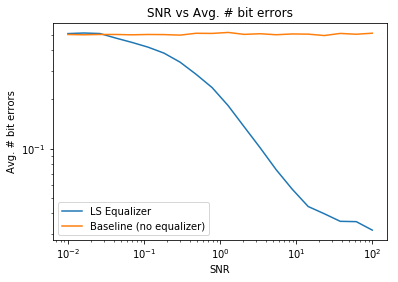

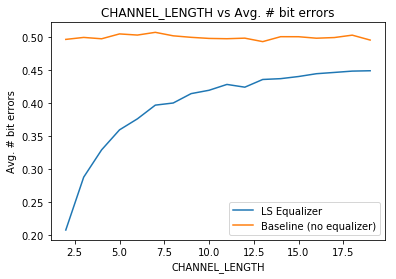

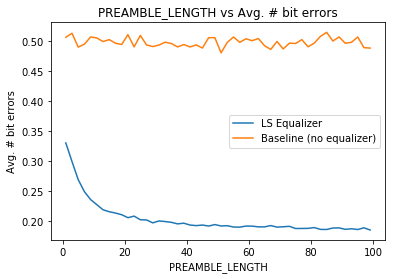

In [23]:
# plot metric: SNR
SNRs = np.logspace(-2., 2, 20)
plot_metric("snr", SNRs, log=True)


# plot metric: channel length
channels = np.arange(2, 20, 1)
plot_metric("channel_length", channels)


# plot metric: preamble length
preambles = np.arange(1, 100, 2)
plot_metric("preamble_length", preambles)
